In [3]:
import pandas as pd
import re
from pathlib import Path

# === 1) اقرأ ملفك ===
# إذا اسم ملفك "spam email.csv" غيّر السطر التالي لاسمك الفعلي (مثلاً "spam.csv")
src = Path("spam email.csv")  # أو Path("spam.csv")
df = pd.read_csv(src)

# === 2) أعِد تسمية الأعمدة (حسب ملفك العربي) ===
df = df.rename(columns={"نص": "Original email", "رسائل إلكترونية مزعجة": "email type"})

# === 3) دالة تنظيف للنص العربي ===
def clean_arabic_text(text: str) -> str:
    text = str(text)
    text = re.sub(r"http\S+|www\.\S+", " ", text)      # إحذف الروابط
    text = re.sub(r"\d+", " ", text)                   # إحذف الأرقام
    text = re.sub(r"[A-Za-z]+", " ", text)             # إحذف حروف إنجليزية
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)    # إبقِ العربية والمسافات
    text = re.sub(r"\s+", " ", text).strip()           # مسافة وحدة
    return text

# === 4) طبّق التنظيف ===
df["Final Text Email"] = df["Original email"].apply(clean_arabic_text)

# === 5) خذ الأعمدة المطلوبة فقط ===
df_new = df[["Final Text Email", "email type"]]

# === 6) احفظ بجانب ملف الإدخال (بدون مسار مطلق) ===
out_path = src.with_name("ArabicPhishingEmails_clean.csv")
df_new.to_csv(out_path, index=False, encoding="utf-8-sig")

print("Saved ->", out_path)
print(df_new.head())


Saved -> ArabicPhishingEmails_clean.csv
                                    Final Text Email email type
0  الموضوع هوية شركتك لا تُقاوم بطبيعتها من الصعب...          1
1  الموضوع فاني، تاجرة الأسهم، المسدسة، هي ميريل،...          1
2  الموضوع منازل جديدة لا تصدق أصبحت سهلة أريد أن...          1
3  الموضوع طلب خاص لطباعة ألوان، لمزيد من المعلوم...          1
4  الموضوع ليس لديّ مال، احصل على أقراص برامج من ...          1


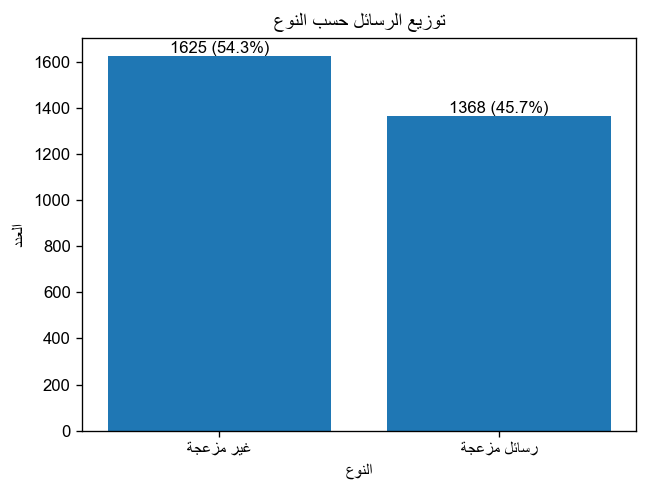

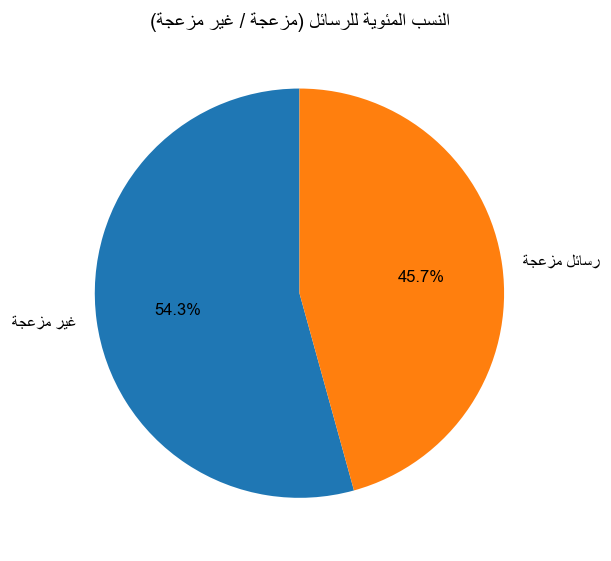

=== Summary ===
غير مزعجة: 1625 (54.3%)
رسائل مزعجة: 1368 (45.7%)
المجموع: 2993


In [6]:
# !pip install arabic-reshaper python-bidi

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import arabic_reshaper
from bidi.algorithm import get_display

# ---------- إعدادات ----------
CSV_PATH = "ArabicPhishingEmails_clean.csv"         # عدّل لمسار ملفك
LABEL_COL_NAME = "email type"    # اسم عمود الليبل عندك

AR_SPAM = "رسائل مزعجة"
AR_HAM  = "غير مزعجة"

def ar(s: str) -> str:
    return get_display(arabic_reshaper.reshape(str(s)))

def set_arabic_font():
    preferred = ["Noto Naskh Arabic", "Noto Sans Arabic", "Arial", "Amiri", "Geeza Pro", "Tahoma"]
    available = set(f.name for f in matplotlib.font_manager.fontManager.ttflist)
    for f in preferred:
        if f in available:
            matplotlib.rcParams["font.family"] = f
            break
    matplotlib.rcParams["axes.unicode_minus"] = False

set_arabic_font()

# ---------- قراءة البيانات ----------
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

# تأكيد القيم 0/1
def normalize_label(x):
    try:
        return int(float(str(x).strip()))
    except:
        return None

df["_label_bin"] = df[LABEL_COL_NAME].apply(normalize_label)
df = df[df["_label_bin"].isin([0, 1])].copy()
if df.empty:
    raise ValueError("ما فيه صفوف صالحة بعد التنظيف. تأكد من القيم 0 و 1 في عمود emailtype.")

# ---------- إحصائيات ----------
# ترتيب القيم بحيث 0 = not spam (غير مزعجة) ، 1 = spam (مزعجة)
counts = df["_label_bin"].value_counts().reindex([0, 1], fill_value=0)
labels_ar = [AR_HAM, AR_SPAM]
counts_list = [counts.get(0, 0), counts.get(1, 0)]
total = sum(counts_list)
percentages = [c*100/total if total else 0 for c in counts_list]

# ---------- Bar Chart ----------
plt.figure(figsize=(5.5,4.2), dpi=120)
bars = plt.bar([ar(AR_HAM), ar(AR_SPAM)], counts_list)
plt.title(ar("توزيع الرسائل حسب النوع"))
plt.xlabel(ar("النوع"))
plt.ylabel(ar("العدد"))
for b, c, p in zip(bars, counts_list, percentages):
    plt.text(b.get_x()+b.get_width()/2, b.get_height(), f"{c} ({p:.1f}%)",
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# ---------- Pie Chart ----------
plt.figure(figsize=(5.2,5.2), dpi=120)
plt.pie(counts_list, labels=[ar(AR_HAM), ar(AR_SPAM)], autopct="%1.1f%%", startangle=90)
plt.title(ar("النسب المئوية للرسائل (مزعجة / غير مزعجة)"))
plt.tight_layout()
plt.show()

# ملخص
print("=== Summary ===")
print(f"{AR_HAM}: {counts_list[0]} ({percentages[0]:.1f}%)")
print(f"{AR_SPAM}: {counts_list[1]} ({percentages[1]:.1f}%)")
print(f"المجموع: {total}")

In [14]:
# !pip install scikit-learn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

# ===== Settings =====
CSV_PATH = "ArabicPhishingEmails_clean.csv"
TEXT_COL = "Final Text Email"
LABEL_COL = "email type"
TEST_SIZE = 0.2
RANDOM_STATE = 42

# ===== Load =====
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")

# ===== Label normalization to 0/1 =====
def to_bin(x):
    s = str(x).strip().lower()
    if s in {"1","spam","true","yes","y"}: return 1
    if s in {"0","ham","not spam","false","no","n"}: return 0
    try:
        return int(float(s))
    except:
        return np.nan

df[LABEL_COL] = df[LABEL_COL].apply(to_bin)
df[TEXT_COL] = df[TEXT_COL].astype(str).str.strip()
df = df.dropna(subset=[LABEL_COL])
df = df[df[LABEL_COL].isin([0,1])]
df = df[df[TEXT_COL].str.len() > 0].drop_duplicates(subset=[TEXT_COL]).reset_index(drop=True)

# sanity
cls_counts = df[LABEL_COL].value_counts().to_dict()
if not all(k in cls_counts for k in [0,1]):
    raise ValueError(f"Both classes 0 and 1 are required. Found: {cls_counts}")

# ===== Split =====
use_stratify = min(cls_counts[0], cls_counts[1]) >= 2
X_train, X_test, y_train, y_test = train_test_split(
    df[TEXT_COL].values, df[LABEL_COL].astype(int).values,
    test_size=TEST_SIZE, random_state=RANDOM_STATE,
    stratify=y_train if False else (df[LABEL_COL].values if use_stratify else None)
)
# Note: sklearn wants the stratify array aligned with X; rebuild to avoid confusion:
if use_stratify:
    X_train, X_test, y_train, y_test = train_test_split(
        df[TEXT_COL].values, df[LABEL_COL].astype(int).values,
        test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df[LABEL_COL].values
    )

# ===== Vectorizer =====
vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    max_features=5000,  # زيدها لو عندك RAM كافية
    lowercase=True
)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

# ===== Models =====
models = {
    "LinearSVC": LinearSVC(C=1.0),
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "ComplementNB": ComplementNB()  # سريع جداً مع نصوص
}

results = []

for name, clf in models.items():
    clf.fit(X_train_vec, y_train)
    y_pred = clf.predict(X_test_vec)

    acc = accuracy_score(y_test, y_pred)
    # metrics for Spam class = 1
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, labels=[1], average='binary', zero_division=0
    )

    print("="*70)
    print(f"Model: {name}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["Not Spam","Spam"], zero_division=0))
    print("Confusion Matrix [rows=true, cols=pred]:")
    print(confusion_matrix(y_test, y_pred))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision(Spam)": prec,
        "Recall(Spam)": rec,
        "F1(Spam)": f1
    })

# ===== Summary Table =====
summary = pd.DataFrame(results).sort_values(by="F1(Spam)", ascending=False).reset_index(drop=True)
print("\n===== Model Comparison (sorted by F1 for Spam) =====")
print(summary.to_string(index=False))


Model: LinearSVC

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.98      0.99      0.98       318
        Spam       0.98      0.97      0.98       267

    accuracy                           0.98       585
   macro avg       0.98      0.98      0.98       585
weighted avg       0.98      0.98      0.98       585

Confusion Matrix [rows=true, cols=pred]:
[[314   4]
 [  8 259]]
Model: LogisticRegression

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.98      0.97      0.97       318
        Spam       0.97      0.97      0.97       267

    accuracy                           0.97       585
   macro avg       0.97      0.97      0.97       585
weighted avg       0.97      0.97      0.97       585

Confusion Matrix [rows=true, cols=pred]:
[[309   9]
 [  7 260]]
Model: ComplementNB

Classification Report:
              precision    recall  f1-score   support

    Not Spam       0.97     

/opt/anaconda3/envs/nlp/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
